In [1]:
import itertools
import os
from deepface import DeepFace
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(" GPU trouvé:", physical_devices)
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("GPU non trouvé, le processeur sera utilisé.")

 GPU trouvé: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
def run_model(detector_backend, dataset):
    expand_percentages = [0, 10, 20]
    align_options = [True, False]
    all_results = []
    
    if dataset == "facial_emotion_detection_dataset":
        dataset_path = "../datasets/facial_emotion_detection_dataset_cropped"
        emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
        save_directory = "informations_facial_emotion_detection_dataset/" + detector_backend
    elif dataset == "CK+":
        dataset_path = "../datasets/CK+48"
        emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise']
        save_directory = "informations_ck_plus/" + detector_backend

    print(f"\n \033[1m{detector_backend} - {dataset}\033[0m")
    
    fig, axes = plt.subplots(3, 2, figsize=(12, 18))  
    axes = axes.flatten() 
    
    for idx, (expand, align) in enumerate(itertools.product(expand_percentages, align_options)):
        print(f"\n--- Test: expand_percentage={expand}, align={align} ---")
        start_time = time.time()

        true_labels = []
        pred_labels = []
        confidences = []
    
        for emotion in emotion_labels:
            emotion_folder = os.path.join(dataset_path, emotion)
            if not os.path.isdir(emotion_folder):
                continue
            for img_file in os.listdir(emotion_folder):
                if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(emotion_folder, img_file)
                    result = DeepFace.analyze(
                        img_path=img_path,
                        actions=['emotion'],
                        enforce_detection=False,
                        detector_backend=detector_backend,
                        align=align,
                        expand_percentage=expand,
                        silent=True
                    )
                    if not result:
                        continue
                    predicted = result[0]['dominant_emotion']
                    if dataset=="CK+"  and predicted=="neutral":
                        result[0]['emotion'].pop("neutral")
                        predicted = max(result[0]['emotion'], key=result[0]['emotion'].get)

                    emotion_result = result[0]['emotion']
                    confidence = emotion_result.get(predicted, 0.0)

                    true_labels.append(emotion)
                    pred_labels.append(predicted)
                    confidences.append(confidence)
    
        if not true_labels:
            print("No predictions for this config, skipping confusion matrix.")
            continue
    
        acc = accuracy_score(true_labels, pred_labels)
        f1 = f1_score(true_labels, pred_labels, average='macro', zero_division=0)
        avg_conf = np.mean(confidences)
        end_time = time.time()
        elapsed_time = end_time - start_time
        all_results.append(((expand, align), acc, f1, avg_conf, elapsed_time))
        
        elapsed_hours, elapsed_minutes, elapsed_seconds= int(elapsed_time // 3600), int((elapsed_time % 3600) // 60), int(elapsed_time % 60)

        print(f"Accuracy: {acc:.4f} | F1: {f1:.4f} | Avg Confidence: {avg_conf:.2f} | Elapsed Time: {elapsed_hours}h {elapsed_minutes}m {elapsed_seconds}s")
    
        used_labels = sorted(set(true_labels + pred_labels))
        cm = confusion_matrix(true_labels, pred_labels, labels=used_labels)
        
        ax = axes[idx]
        sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=used_labels, yticklabels=used_labels, ax=ax)
        ax.set_title(f"expand={expand}, align={align}")
        ax.set_xlabel("Classe Estimée")
        ax.set_ylabel("Classe Réelle")

    
    fig.suptitle(f"{detector_backend} - {dataset} - Confusion Matrices", fontsize=20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    filename = f"{detector_backend}_confusion_matrices.png"
    filepath = os.path.join(save_directory, filename)
    os.makedirs(save_directory, exist_ok=True)
    
    fig.savefig(filepath)
    fig.set_dpi(60)
    plt.show()
    plt.close()
        
    results_txt_path = os.path.join(save_directory, f"{detector_backend}_results_summary.txt")
    
    with open(results_txt_path, "w", encoding="utf-8") as f:
        for (expand, align), acc, f1, conf, elapsed in all_results:
            elapsed_hours = int(elapsed // 3600)
            elapsed_minutes = int((elapsed % 3600) // 60)
            elapsed_seconds = int(elapsed % 60)
            f.write(f"--- Test: expand_percentage={expand}, align={align} ---\n")
            f.write(f"Accuracy: {acc:.4f} | F1: {f1:.4f} | Avg Confidence: {conf:.2f}\n\n")
            f.write(f"Elapsed Time: {elapsed_hours}h {elapsed_minutes}m {elapsed_seconds}s\n\n")

    
    print(f"\n Résultats enregistrés dans {results_txt_path}")



 opencv - CK+

--- Test: expand_percentage=0, align=True ---
Accuracy: 0.5750 | F1: 0.4582 | Avg Confidence: 74.89 | Elapsed Time: 0h 0m 18s

--- Test: expand_percentage=0, align=False ---
Accuracy: 0.6052 | F1: 0.5111 | Avg Confidence: 75.25 | Elapsed Time: 0h 0m 8s

--- Test: expand_percentage=10, align=True ---
Accuracy: 0.5264 | F1: 0.3990 | Avg Confidence: 73.02 | Elapsed Time: 0h 0m 13s

--- Test: expand_percentage=10, align=False ---
Accuracy: 0.6030 | F1: 0.5054 | Avg Confidence: 74.89 | Elapsed Time: 0h 0m 8s

--- Test: expand_percentage=20, align=True ---
Accuracy: 0.4984 | F1: 0.3832 | Avg Confidence: 72.12 | Elapsed Time: 0h 0m 13s

--- Test: expand_percentage=20, align=False ---
Accuracy: 0.6009 | F1: 0.5002 | Avg Confidence: 75.40 | Elapsed Time: 0h 0m 10s


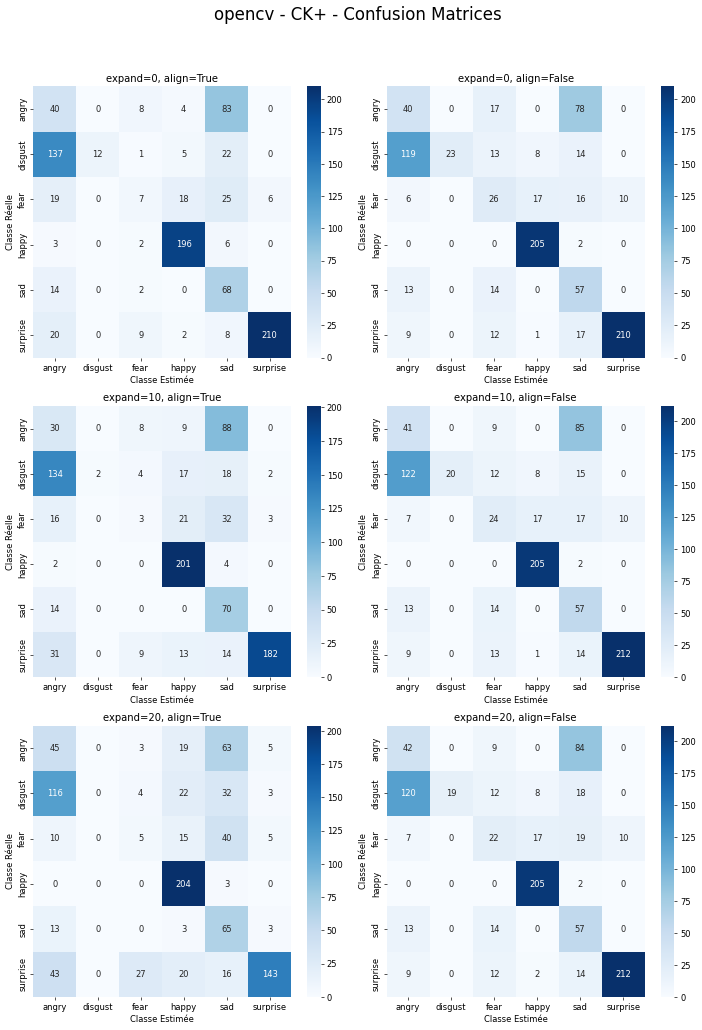


 Résultats enregistrés dans informations_ck_plus/opencv\opencv_results_summary.txt


In [4]:
run_model("opencv", "CK+")


 ssd - CK+

--- Test: expand_percentage=0, align=True ---
Accuracy: 0.5901 | F1: 0.4782 | Avg Confidence: 75.69 | Elapsed Time: 0h 0m 38s

--- Test: expand_percentage=0, align=False ---
Accuracy: 0.2125 | F1: 0.1926 | Avg Confidence: 83.11 | Elapsed Time: 0h 0m 41s

--- Test: expand_percentage=10, align=True ---
Accuracy: 0.5685 | F1: 0.4589 | Avg Confidence: 76.14 | Elapsed Time: 0h 0m 40s

--- Test: expand_percentage=10, align=False ---
Accuracy: 0.2255 | F1: 0.2044 | Avg Confidence: 83.39 | Elapsed Time: 0h 0m 39s

--- Test: expand_percentage=20, align=True ---
Accuracy: 0.5286 | F1: 0.4185 | Avg Confidence: 73.63 | Elapsed Time: 0h 0m 40s

--- Test: expand_percentage=20, align=False ---
Accuracy: 0.2999 | F1: 0.2644 | Avg Confidence: 85.21 | Elapsed Time: 0h 0m 37s


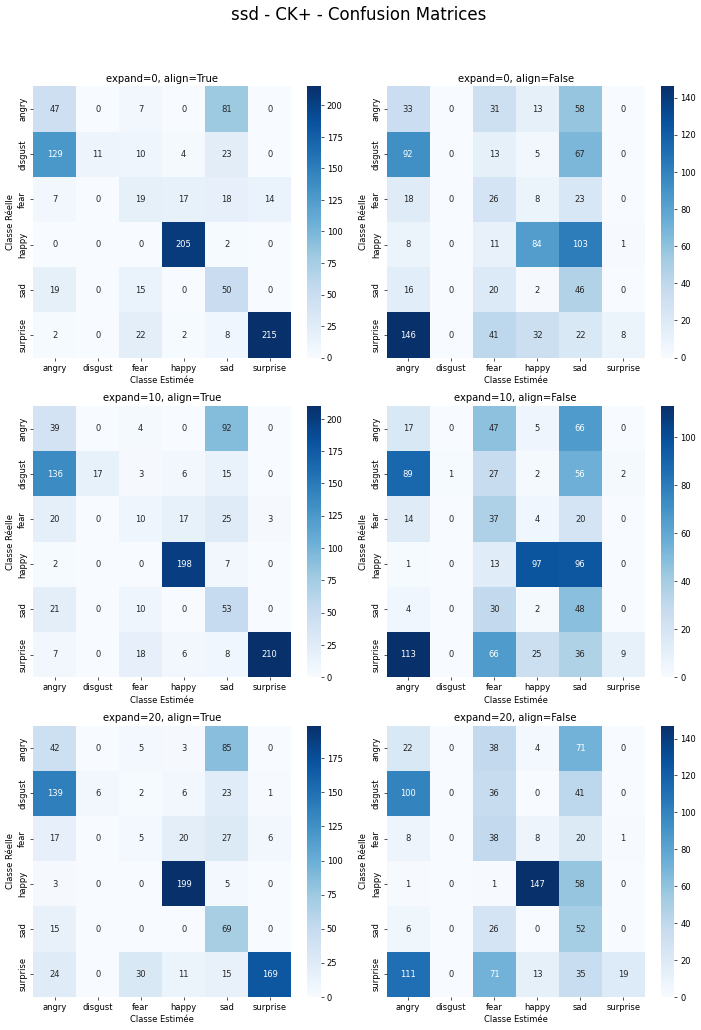


 Résultats enregistrés dans informations_ck_plus/ssd\ssd_results_summary.txt


In [5]:
run_model("ssd", "CK+")


 dlib - CK+

--- Test: expand_percentage=0, align=True ---
Accuracy: 0.5814 | F1: 0.4875 | Avg Confidence: 69.12 | Elapsed Time: 0h 0m 15s

--- Test: expand_percentage=0, align=False ---
Accuracy: 0.5739 | F1: 0.4826 | Avg Confidence: 71.96 | Elapsed Time: 0h 0m 9s

--- Test: expand_percentage=10, align=True ---
Accuracy: 0.5728 | F1: 0.4755 | Avg Confidence: 69.28 | Elapsed Time: 0h 0m 15s

--- Test: expand_percentage=10, align=False ---
Accuracy: 0.5825 | F1: 0.4853 | Avg Confidence: 71.06 | Elapsed Time: 0h 0m 12s

--- Test: expand_percentage=20, align=True ---
Accuracy: 0.5566 | F1: 0.4480 | Avg Confidence: 75.51 | Elapsed Time: 0h 0m 16s

--- Test: expand_percentage=20, align=False ---
Accuracy: 0.6127 | F1: 0.5027 | Avg Confidence: 71.02 | Elapsed Time: 0h 0m 10s


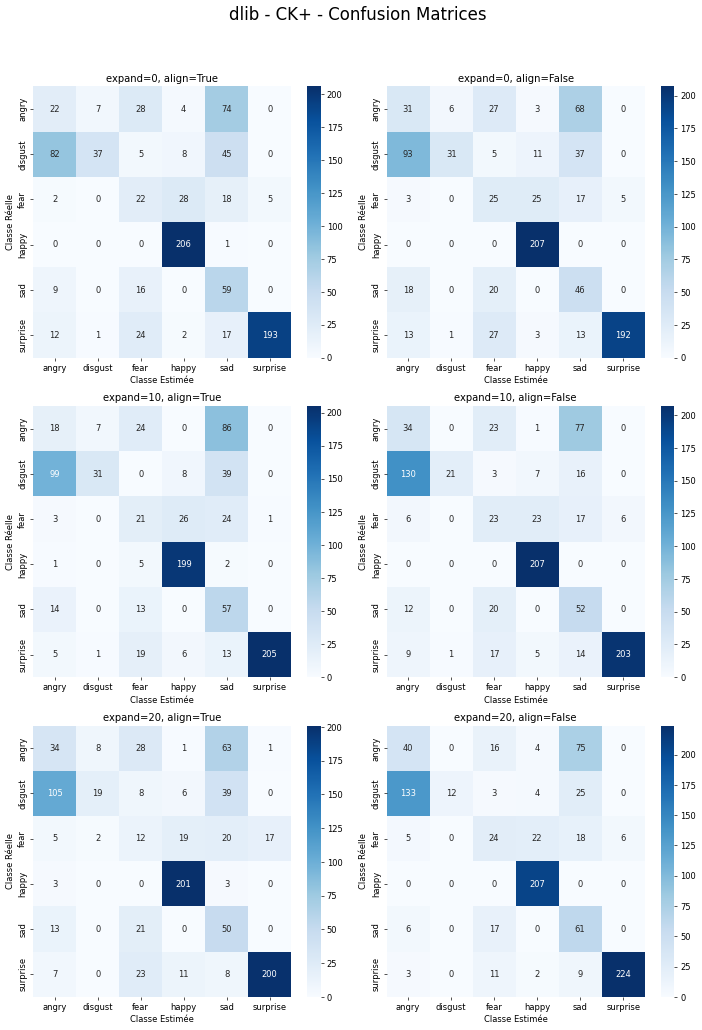


 Résultats enregistrés dans informations_ck_plus/dlib\dlib_results_summary.txt


In [6]:
run_model("dlib", "CK+")


 mtcnn - CK+

--- Test: expand_percentage=0, align=True ---
Accuracy: 0.5750 | F1: 0.4670 | Avg Confidence: 74.05 | Elapsed Time: 0h 6m 12s

--- Test: expand_percentage=0, align=False ---
Accuracy: 0.5901 | F1: 0.4799 | Avg Confidence: 74.26 | Elapsed Time: 0h 4m 31s

--- Test: expand_percentage=10, align=True ---
Accuracy: 0.5426 | F1: 0.4397 | Avg Confidence: 74.48 | Elapsed Time: 0h 7m 12s

--- Test: expand_percentage=10, align=False ---
Accuracy: 0.5825 | F1: 0.4729 | Avg Confidence: 75.23 | Elapsed Time: 0h 5m 19s

--- Test: expand_percentage=20, align=True ---
Accuracy: 0.5232 | F1: 0.4218 | Avg Confidence: 72.54 | Elapsed Time: 0h 7m 36s

--- Test: expand_percentage=20, align=False ---
Accuracy: 0.5868 | F1: 0.4850 | Avg Confidence: 74.65 | Elapsed Time: 0h 5m 29s


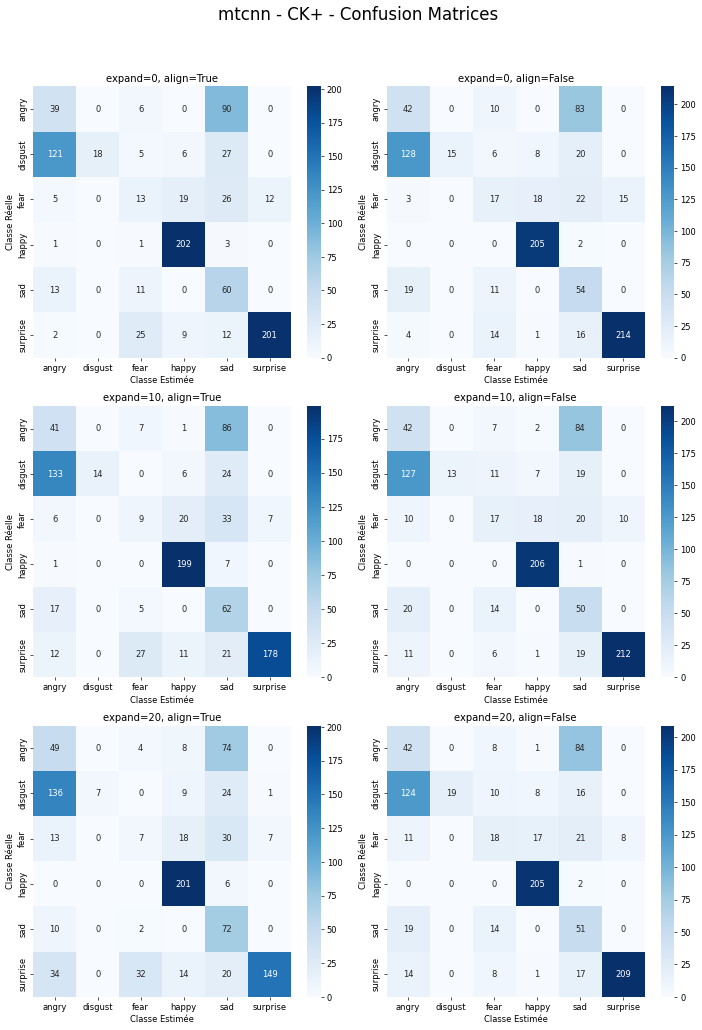


 Résultats enregistrés dans informations_ck_plus/mtcnn\mtcnn_results_summary.txt


In [7]:
run_model("mtcnn", "CK+")


 fastmtcnn - CK+

--- Test: expand_percentage=0, align=True ---
Accuracy: 0.5771 | F1: 0.4758 | Avg Confidence: 70.93 | Elapsed Time: 0h 0m 43s

--- Test: expand_percentage=0, align=False ---
Accuracy: 0.5133 | F1: 0.4275 | Avg Confidence: 76.72 | Elapsed Time: 0h 0m 28s

--- Test: expand_percentage=10, align=True ---
Accuracy: 0.5415 | F1: 0.4470 | Avg Confidence: 73.13 | Elapsed Time: 0h 0m 37s

--- Test: expand_percentage=10, align=False ---
Accuracy: 0.5933 | F1: 0.4966 | Avg Confidence: 74.18 | Elapsed Time: 0h 0m 29s

--- Test: expand_percentage=20, align=True ---
Accuracy: 0.4844 | F1: 0.3938 | Avg Confidence: 72.59 | Elapsed Time: 0h 0m 43s

--- Test: expand_percentage=20, align=False ---
Accuracy: 0.5987 | F1: 0.4989 | Avg Confidence: 75.12 | Elapsed Time: 0h 0m 30s


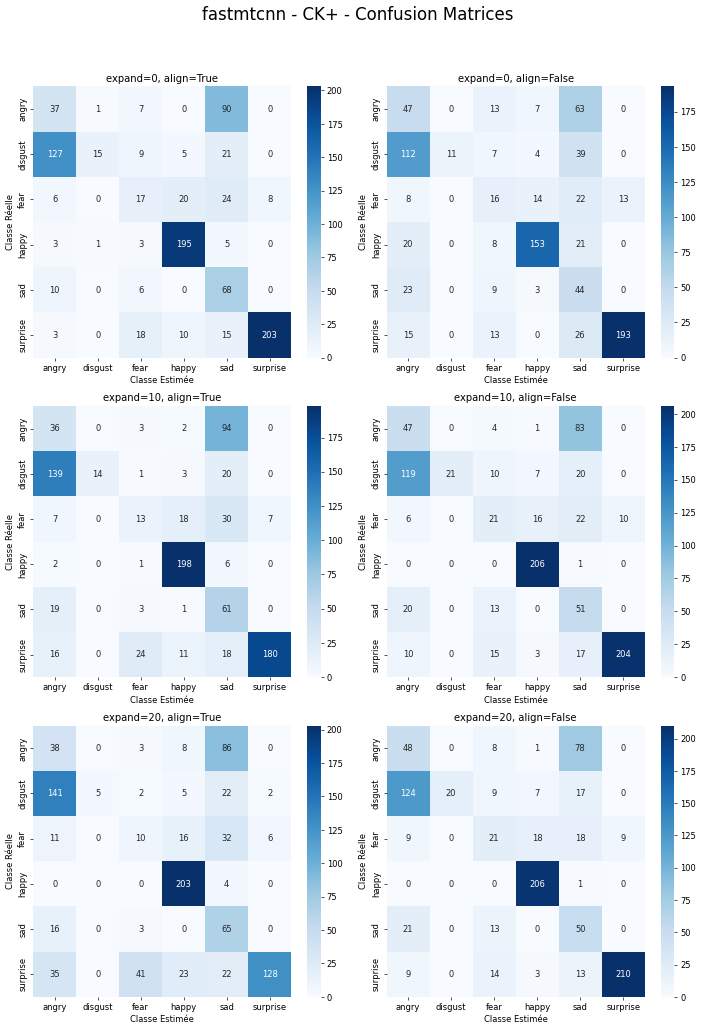


 Résultats enregistrés dans informations_ck_plus/fastmtcnn\fastmtcnn_results_summary.txt


In [8]:
run_model("fastmtcnn", "CK+")          


 retinaface - CK+

--- Test: expand_percentage=0, align=True ---
Accuracy: 0.5793 | F1: 0.4664 | Avg Confidence: 73.26 | Elapsed Time: 0h 4m 45s

--- Test: expand_percentage=0, align=False ---
Accuracy: 0.5804 | F1: 0.4850 | Avg Confidence: 74.74 | Elapsed Time: 0h 4m 44s

--- Test: expand_percentage=10, align=True ---
Accuracy: 0.5566 | F1: 0.4533 | Avg Confidence: 72.92 | Elapsed Time: 0h 4m 43s

--- Test: expand_percentage=10, align=False ---
Accuracy: 0.5836 | F1: 0.4898 | Avg Confidence: 74.36 | Elapsed Time: 0h 4m 50s

--- Test: expand_percentage=20, align=True ---
Accuracy: 0.4833 | F1: 0.3845 | Avg Confidence: 68.41 | Elapsed Time: 0h 9m 26s

--- Test: expand_percentage=20, align=False ---
Accuracy: 0.5879 | F1: 0.4944 | Avg Confidence: 73.99 | Elapsed Time: 0h 11m 12s


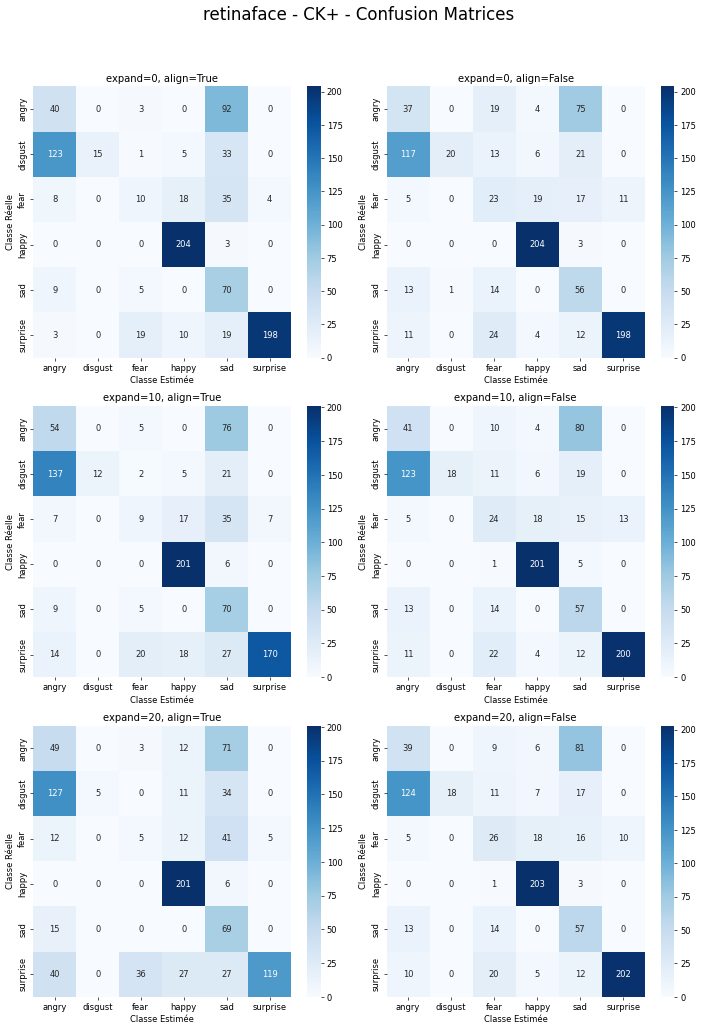


 Résultats enregistrés dans informations_ck_plus/retinaface\retinaface_results_summary.txt


In [9]:
run_model("retinaface", "CK+")


 yolov8 - CK+

--- Test: expand_percentage=0, align=True ---
Accuracy: 0.5933 | F1: 0.4953 | Avg Confidence: 73.78 | Elapsed Time: 0h 1m 49s

--- Test: expand_percentage=0, align=False ---
Accuracy: 0.5825 | F1: 0.4778 | Avg Confidence: 75.21 | Elapsed Time: 0h 1m 46s

--- Test: expand_percentage=10, align=True ---
Accuracy: 0.5890 | F1: 0.4875 | Avg Confidence: 74.95 | Elapsed Time: 0h 1m 48s

--- Test: expand_percentage=10, align=False ---
Accuracy: 0.6009 | F1: 0.4997 | Avg Confidence: 75.08 | Elapsed Time: 0h 1m 45s

--- Test: expand_percentage=20, align=True ---
Accuracy: 0.5566 | F1: 0.4376 | Avg Confidence: 74.12 | Elapsed Time: 0h 1m 47s

--- Test: expand_percentage=20, align=False ---
Accuracy: 0.6073 | F1: 0.5091 | Avg Confidence: 75.27 | Elapsed Time: 0h 1m 45s


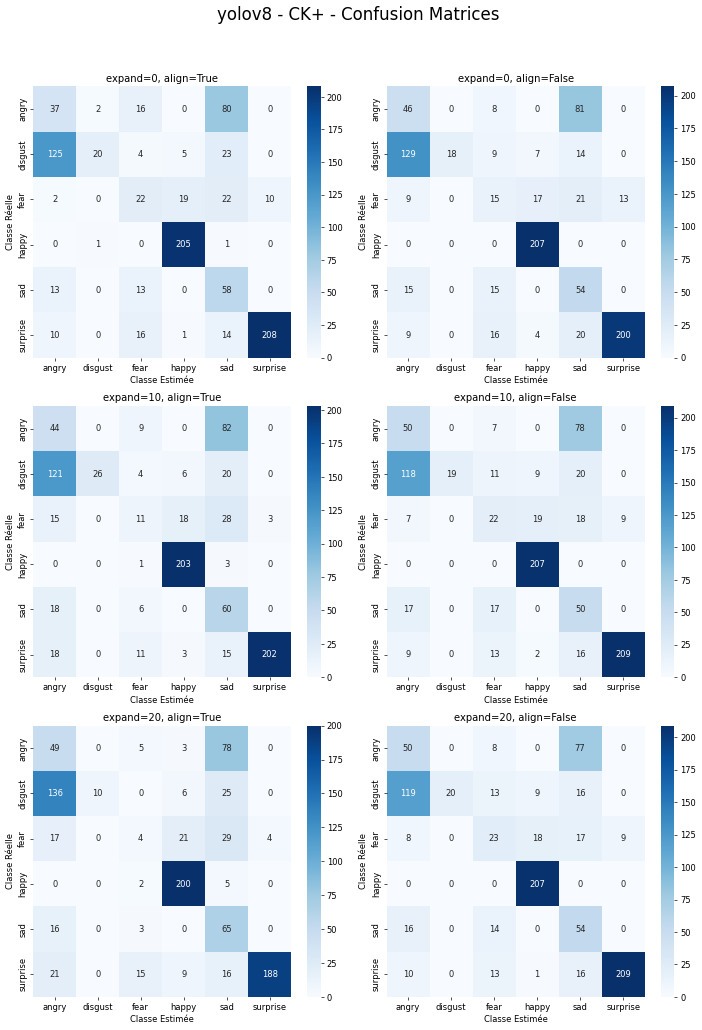


 Résultats enregistrés dans informations_ck_plus/yolov8\yolov8_results_summary.txt


In [10]:
run_model("yolov8", "CK+")


 yunet - CK+

--- Test: expand_percentage=0, align=True ---
Accuracy: 0.5955 | F1: 0.4900 | Avg Confidence: 75.25 | Elapsed Time: 0h 0m 19s

--- Test: expand_percentage=0, align=False ---
Accuracy: 0.5901 | F1: 0.4849 | Avg Confidence: 72.40 | Elapsed Time: 0h 0m 15s

--- Test: expand_percentage=10, align=True ---
Accuracy: 0.5847 | F1: 0.4775 | Avg Confidence: 75.55 | Elapsed Time: 0h 0m 19s

--- Test: expand_percentage=10, align=False ---
Accuracy: 0.6052 | F1: 0.5038 | Avg Confidence: 74.46 | Elapsed Time: 0h 0m 15s

--- Test: expand_percentage=20, align=True ---
Accuracy: 0.5728 | F1: 0.4666 | Avg Confidence: 75.33 | Elapsed Time: 0h 0m 18s

--- Test: expand_percentage=20, align=False ---
Accuracy: 0.5965 | F1: 0.4975 | Avg Confidence: 74.50 | Elapsed Time: 0h 0m 15s


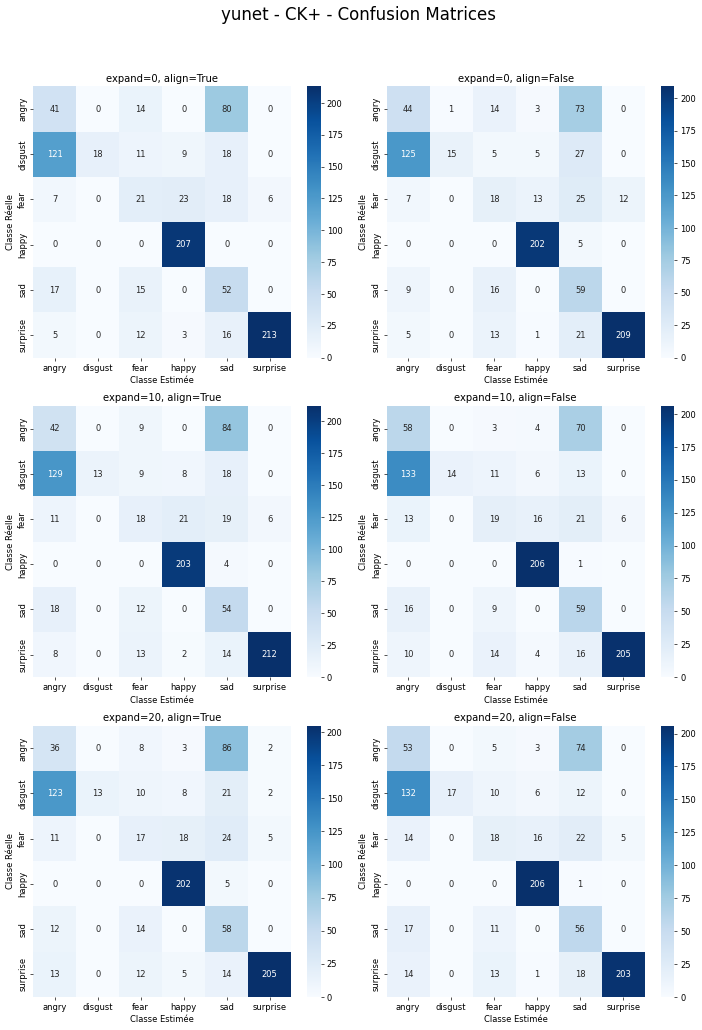


 Résultats enregistrés dans informations_ck_plus/yunet\yunet_results_summary.txt


In [11]:
run_model("yunet", "CK+")


 centerface - CK+

--- Test: expand_percentage=0, align=True ---
Accuracy: 0.6030 | F1: 0.5030 | Avg Confidence: 75.41 | Elapsed Time: 0h 2m 42s

--- Test: expand_percentage=0, align=False ---
Accuracy: 0.6084 | F1: 0.5119 | Avg Confidence: 75.73 | Elapsed Time: 0h 2m 20s

--- Test: expand_percentage=10, align=True ---
Accuracy: 0.6019 | F1: 0.5022 | Avg Confidence: 75.50 | Elapsed Time: 0h 3m 5s

--- Test: expand_percentage=10, align=False ---
Accuracy: 0.6138 | F1: 0.5159 | Avg Confidence: 74.83 | Elapsed Time: 0h 3m 43s

--- Test: expand_percentage=20, align=True ---
Accuracy: 0.5998 | F1: 0.4999 | Avg Confidence: 75.56 | Elapsed Time: 0h 2m 20s

--- Test: expand_percentage=20, align=False ---
Accuracy: 0.6052 | F1: 0.5059 | Avg Confidence: 75.39 | Elapsed Time: 0h 2m 16s


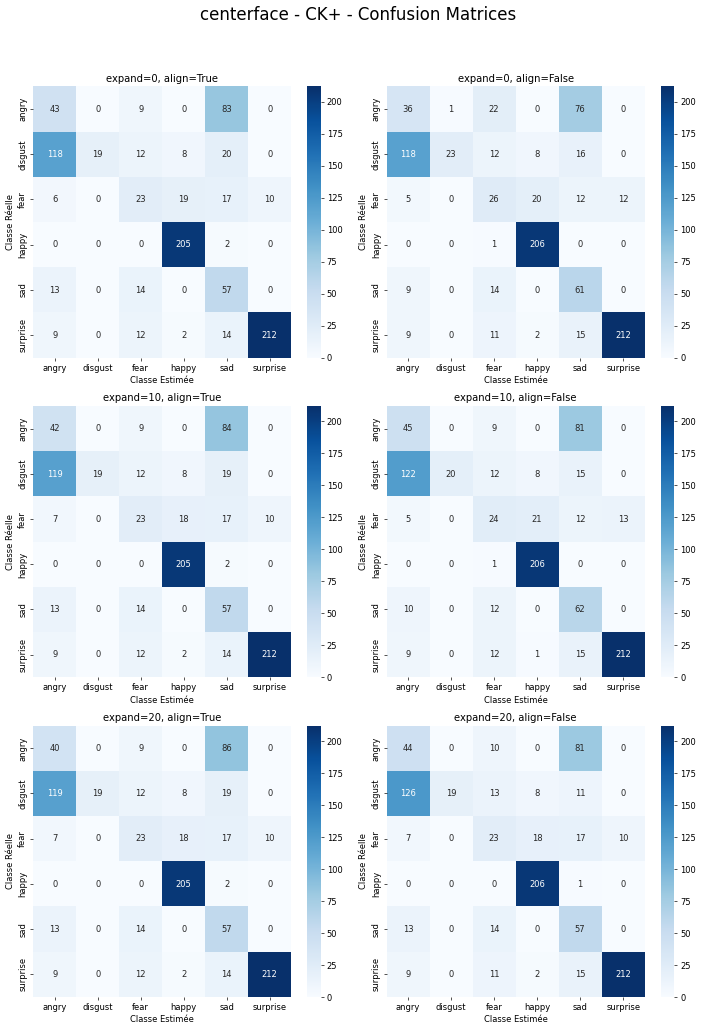


 Résultats enregistrés dans informations_ck_plus/centerface\centerface_results_summary.txt


In [12]:
run_model("centerface", "CK+")